In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#load ultra data base
from utils_functions.structure import *

In [42]:
udb = load_structure("./data/ultradf_v4.json")
rep = pd.read_csv('reprogramming_mouse_full.csv', index_col=0)

In [43]:
#accepted datasets of signature
datasets = ['GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
        'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
        'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
        'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
        'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
        'GSE127927$7F-Sall4', 'GSE127927$7F', 
        'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1']

In [4]:
top = 5
interval = 2

pos_genes = rep[rep.logFC > 0].sort_values('P.Value', ascending=True).iloc[:top, :]
neg_genes = rep[rep.logFC < 0].sort_values('P.Value', ascending=True).iloc[:top, :]
my_genes = rep[rep.symbol == 'Rragc']

genes = pos_genes.append(neg_genes).append(my_genes)

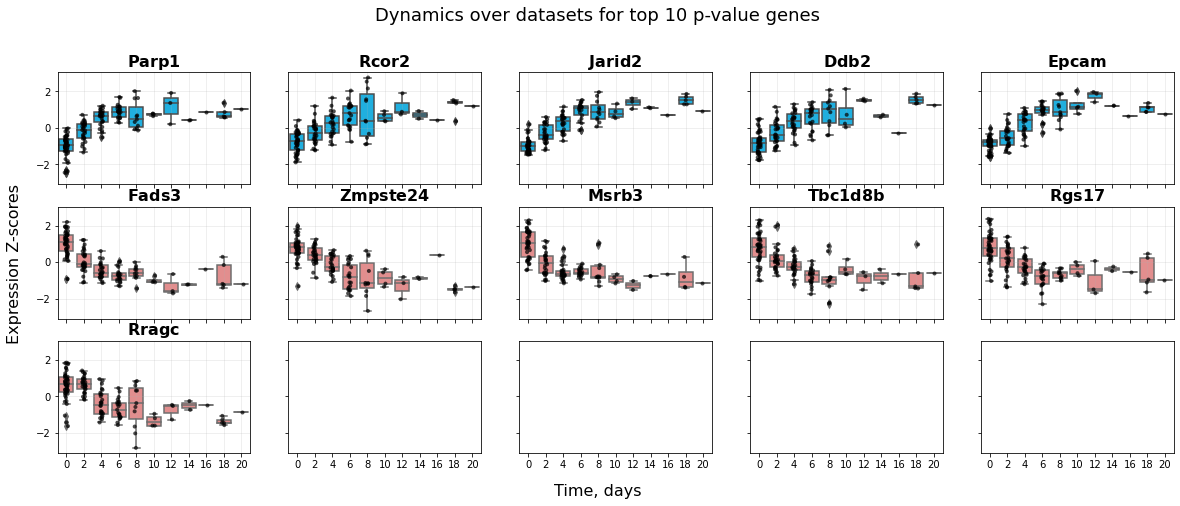

In [5]:
fig, axes = plt.subplots(3, top, figsize=(4 * top, 3*2 + 1), sharex=True, sharey=True)
fig.text(0.5, 0.04, 'Time, days', ha='center', fontsize=16)
fig.text(0.09, 0.5, 'Expression Z-scores', va='center', fontsize=16, rotation='vertical')
fig.suptitle('Dynamics over datasets for top %d p-value genes' % (top * 2), fontsize=18, y=1.01)

i = 0
for (_, g), ax in zip(genes.iterrows(), axes.flatten()):
    color = 'deepskyblue' if i < top else 'lightcoral'
    df = pd.DataFrame(columns=['data', 'time', 'dataset'])
    for ds in datasets:
        try:
            data = udb[ds]['data'].loc[g.name].values
        except:
            continue
        data = (data - data.mean()) / data.std(ddof=1) #z-score transform
        time = udb[ds]['time']
        df = df.append(pd.DataFrame({'data':data, 'time':time, 'dataset': [ds] * len(time)}))
    df['group_time'] = df.time // interval * interval

    sns.boxplot(data=df, x='group_time', y='data', color=color, ax=ax)
    sns.stripplot(data=df, x='group_time', y='data', color='black', alpha=0.7, size=4, ax=ax)
    ax.set_title(r'$\bf{%s}$' % g.symbol, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(alpha=0.25)
    i+=1


# Mean dynamics of dataset

In [10]:
datasets = udb.keys()

In [44]:
from functools import reduce

prelist = []
for key in datasets:
    data = udb[key]['data']
    data.columns = [key + '$$' + c for c in data.columns]
    data = data.subtract(data.mean(1), axis='rows')#.div(data.std(1), axis='rows')
    data = data.T
    data['TIME'] = udb[key]['time']
    data = data.T
    prelist.append(data)

db = reduce(lambda x,y: pd.merge(x, y, on='index', how='inner',), prelist).T

In [23]:
#db.T.iloc[:,0:2].to_csv('tmp/temp_universe.csv')

In [46]:
#create new time
interval = 2
db['pTIME'] = db['TIME'] // interval * interval
#filter from nonrepresented values
db = db[~((db['pTIME'] == 14) | (db['pTIME'] == 16) | (db['pTIME'] == 20))]
db = db.dropna(1)

In [47]:
from sklearn.feature_selection import f_classif
from statsmodels.stats.multitest import multipletests

X = db.drop(['TIME', 'pTIME'], 1)
y = db['pTIME']

fstat, pval = f_classif(X, y)
passed, pval_adj, *_ = multipletests(pval, alpha=0.05, method='fdr_bh')

print(' Total: %d\n p-passed: %d\n FDR-passed: %d' % (X.shape[1], sum(pval < 0.05), sum(passed)))

 Total: 7292
 p-passed: 5399
 FDR-passed: 5217


In [48]:
new_db = X.iloc[:, passed]
new_db = new_db.div(new_db.std(1), axis='rows') #scale
new_db['pTIME'] = y
new_db['TIME'] = db['TIME']

In [49]:
new_db

index,11305,11363,11364,11370,11416,11428,11429,11430,11433,11461,...,494504,546071,619605,622404,625249,641340,641376,100037258,pTIME,TIME
GSE67462$OSKM$$GSM1647454,-0.288853,0.860195,0.111290,0.766625,0.033722,-0.074197,-0.214431,0.914989,-0.712939,-0.078715,...,-0.671080,-0.224778,0.016661,0.489492,-0.234898,0.038578,0.075111,0.859529,0.0,0.0
GSE67462$OSKM$$GSM1647455,-0.386324,0.897656,0.088742,0.702561,0.149729,0.017108,-0.278970,0.735562,-0.795722,-0.047071,...,-0.617812,-0.067078,-0.138447,0.559026,-0.189421,0.272040,0.161269,0.881804,0.0,0.0
GSE67462$OSKM$$GSM1647456,-0.828010,-0.608304,-0.254427,0.582903,1.247951,0.141155,-0.798449,0.440625,-0.993814,0.129085,...,-1.371868,-0.330085,1.046313,0.124438,-0.492642,-0.368738,0.119918,1.028932,0.0,1.0
GSE67462$OSKM$$GSM1647457,-1.214540,-0.884237,-0.341643,0.618317,1.450469,-0.001509,-0.632298,0.345654,-0.936362,0.204758,...,-1.509384,-0.334944,1.211554,-0.046161,-0.196692,-0.676326,0.179774,1.113818,0.0,1.0
GSE67462$OSKM$$GSM1647458,0.459154,-0.923390,-0.250301,1.096255,0.885054,0.074113,0.043420,-0.661854,-2.164224,0.224710,...,-1.917551,-0.289963,0.783397,0.105419,-0.420545,0.526680,0.099542,-0.648080,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE102348$OSKM$WT-1$$GSM2735179,-0.243809,-0.236712,-0.099115,-0.650332,0.194369,0.308242,-0.483139,0.413941,-0.388005,0.460287,...,-4.430114,-0.250653,-0.549248,0.136359,-0.260376,-0.340447,-0.289770,0.702692,0.0,0.0
GSE102348$OSKM$WT-1$$GSM2735180,-0.905064,-0.689320,0.615590,-0.282928,0.197735,-0.032509,-0.529633,0.306480,0.029586,0.808573,...,-4.142588,-0.266565,-0.449739,-0.127847,-0.212274,-0.066497,-0.342704,0.894226,2.0,2.0
GSE102348$OSKM$WT-1$$GSM2735181,0.779983,0.319666,0.244559,0.243660,-0.358291,0.202291,0.670944,-0.711615,-0.787615,-0.989583,...,3.328102,0.634847,-0.279569,-0.693198,-0.230868,-0.998935,-0.121044,-0.923427,4.0,4.0
GSE102348$OSKM$WT-1$$GSM2735182,1.587432,0.593819,-0.590206,0.455926,-0.040105,-0.002662,0.434459,-0.233820,-0.441574,-0.503370,...,5.773085,0.454113,0.240546,-0.322893,0.472317,0.822479,0.598978,-0.401636,6.0,6.0


In [50]:
avg_dynamics = new_db.drop('TIME', 1).groupby('pTIME').agg('mean').T

In [51]:
avg_dynamics.to_csv('tmp/mouse_avg_dynamics_19ds.csv')

<AxesSubplot:xlabel='pTIME'>

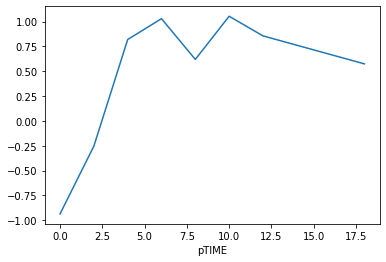

In [52]:
avg_dynamics.loc[11545].plot()#.to_csv('tmp/mouse_avg_dynamics_19ds.csv')


# Check tClock dynamics

In [58]:
avg = pd.read_csv('tmp/mouse_avg_dynamics_19ds.csv', index_col=0)
avg.index = list(map(str, avg.index.tolist()))

In [74]:
import joblib
model = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))

In [75]:
genes = np.array(model.feature_names) #np.array(list(map(str, avg.index.tolist())))
wei = model.coef_
genes_ = genes[wei != 0]
wei_ = wei[wei != 0]

intsec = avg.index.intersection(genes_.tolist()).tolist()

In [76]:
avg.loc[intsec].to_csv('tmp/mouse_avg_dynamics_19ds_clock_selected.csv')

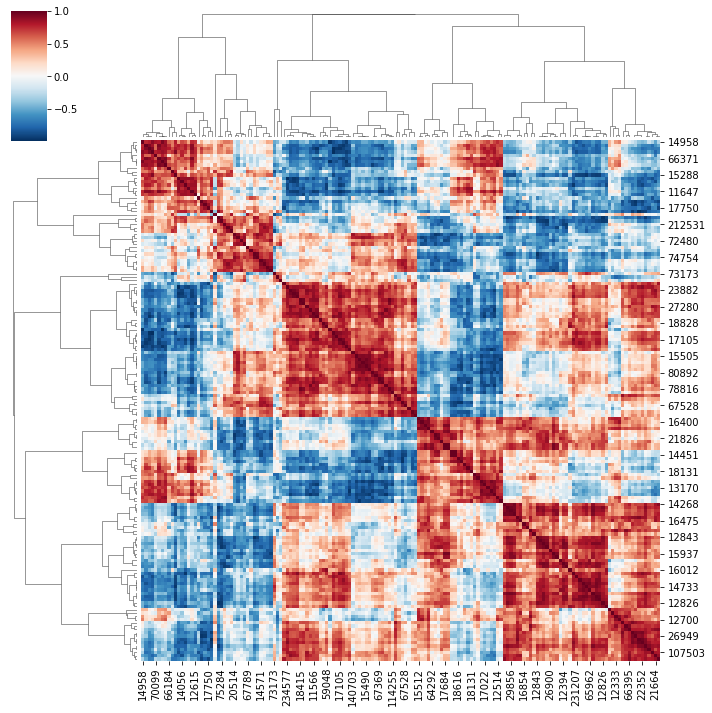

In [77]:
sns.clustermap(avg.loc[intsec].T.corr(), metric='correlation', method='complete', cmap='RdBu_r') 

# ???

In [9]:
h2m = pd.read_csv('utils/human2mouse_entrez.csv', index_col=0)

In [19]:
h2m_map = dict(zip(h2m['human'].values, h2m['mouse'].values))

In [54]:
cols = db.columns.map(h2m_map, na_action=np.nan)
cols = np.array(cols)
~np.isnan(list(cols))

array([ True,  True,  True, ..., False, False, False])

In [61]:
mouseEtz_db = db.T[~np.isnan(list(cols))].T
mouseEtz_db['TIME'] = db['TIME']

In [65]:
#mouseEtz_db.to_csv('data/human_full_data_12ds_mouse_etz.csv')

# Additional

In [59]:
df = pd.read_csv('clocks/Mouse_clock_output.csv', index_col=0)

In [60]:
tf = df

In [61]:
tf.Treatment.unique()

array(['OSKM', 'OSK', 'OK+9MS', 'C/EBPα+ OSKM', 'OSKM+dox_mef',
       '7F-Esrrb', '7F-Glis1', '7F-Jdp2', '7F-Kdm2b', '7F-Mkk6',
       '7F-Nanog', '7F-Sall4', '7F'], dtype=object)

In [62]:
tf

,ID,GEO,Treatment,Time,tAge_norm_mouseClock,tAge_scaled_mouseClock
GSE67462.OSKM.GSM1647454,GSE67462:OSKM,GSE67462,OSKM,0.0,0.152112,0.177560
GSE67462.OSKM.GSM1647455,GSE67462:OSKM,GSE67462,OSKM,0.0,0.131569,0.166540
GSE67462.OSKM.GSM1647456,GSE67462:OSKM,GSE67462,OSKM,1.0,0.108990,0.102617
GSE67462.OSKM.GSM1647457,GSE67462:OSKM,GSE67462,OSKM,1.0,0.106098,0.103676
GSE67462.OSKM.GSM1647458,GSE67462:OSKM,GSE67462,OSKM,3.0,0.072194,0.078807
...,...,...,...,...,...,...
GSE102348.OSKM.WT-1.GSM2735179,GSE102348:OSKM,GSE102348,OSKM,0.0,0.351655,0.425556
GSE102348.OSKM.WT-1.GSM2735180,GSE102348:OSKM,GSE102348,OSKM,2.0,0.395589,0.454813
GSE102348.OSKM.WT-1.GSM2735181,GSE102348:OSKM,GSE102348,OSKM,4.0,0.078564,0.154114
GSE102348.OSKM.WT-1.GSM2735182,GSE102348:OSKM,GSE102348,OSKM,6.0,0.222736,0.275356


In [63]:
import re
pattern = 'GSE\d+.(.*?).GSM'
S = tf.index.tolist()
treat = [re.search(pattern, s).group(1) for s in S]

mapper = {'OKMS':'OSKM'}
treat = [mapper[t] if t in mapper.keys() else t for t in treat ]

tf['Treatment'] = treat
tf['BatchTreatment'] = np.where(tf['Treatment'].str.contains('7F'), '7F', 'OSKM')

In [66]:
tf.to_csv('clocks/Mouse_clock_output.csv')